In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
df = pd.read_csv("Reviews.csv")
print(df.shape)

(568454, 10)


<Axes: title={'center': 'Kind of reviews by starts'}>

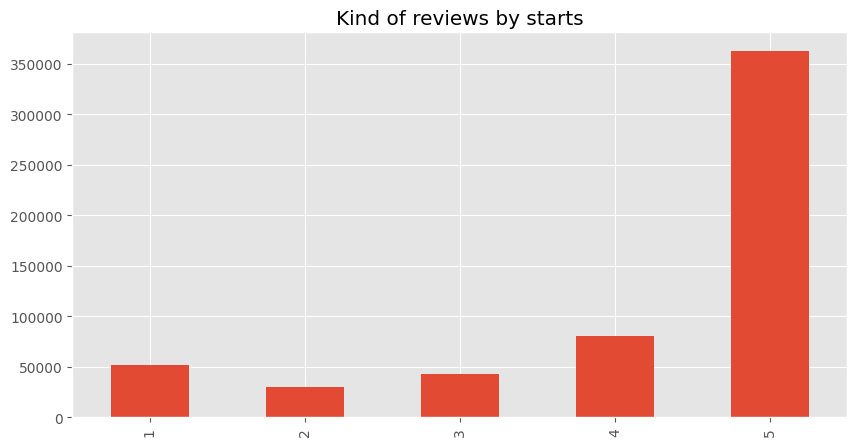

In [3]:
df['Score'].value_counts().sort_index().plot(kind = 'bar', title = "Kind of reviews by starts", figsize = (10,5))

In [4]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [5]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [6]:
tagged = nltk.pos_tag(tokens)
tagged[0:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [7]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint

<bound method Tree.pprint of Tree('S', [('This', 'DT'), ('oatmeal', 'NN'), ('is', 'VBZ'), ('not', 'RB'), ('good', 'JJ'), ('.', '.'), ('Its', 'PRP$'), ('mushy', 'NN'), (',', ','), ('soft', 'JJ'), (',', ','), ('I', 'PRP'), ('do', 'VBP'), ("n't", 'RB'), ('like', 'VB'), ('it', 'PRP'), ('.', '.'), Tree('ORGANIZATION', [('Quaker', 'NNP'), ('Oats', 'NNPS')]), ('is', 'VBZ'), ('the', 'DT'), ('way', 'NN'), ('to', 'TO'), ('go', 'VB'), ('.', '.')])>

In [8]:
## Using VADER for the first model 
## Vader uses a bow method 
from nltk.sentiment import  SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [9]:
sia  = SentimentIntensityAnalyzer( )

In [10]:
sia

In [11]:
sia.polarity_scores('I am very happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [12]:
res = {}
for i, row in tqdm(df.iterrows(), total= len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/568454 [00:00<?, ?it/s]

In [13]:
vaders = pd.DataFrame(res).T

In [15]:
vaders.head()

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.138,0.862,0.000,-0.5664
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468


In [16]:
vaders = vaders.reset_index().rename(columns =  {"index" : "Id"})
vaders = vaders.merge(df, how = 'left')

In [17]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


AttributeError: 'Axes' object has no attribute 'show'

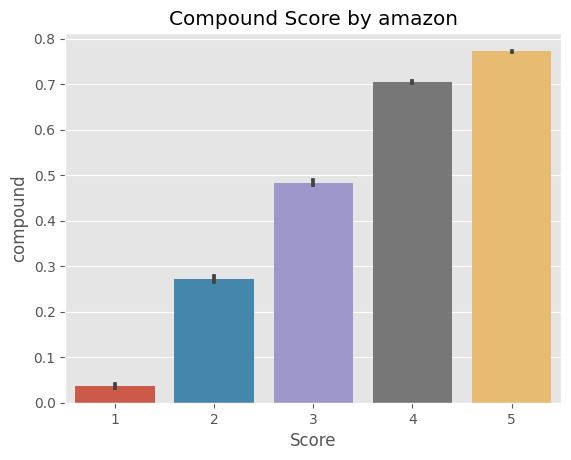

In [19]:
ax = sns.barplot(data = vaders, x = 'Score', y = 'compound')
ax.set_title('Compound Score by amazon')
ax.show()

<Axes: xlabel='Score', ylabel='pos'>

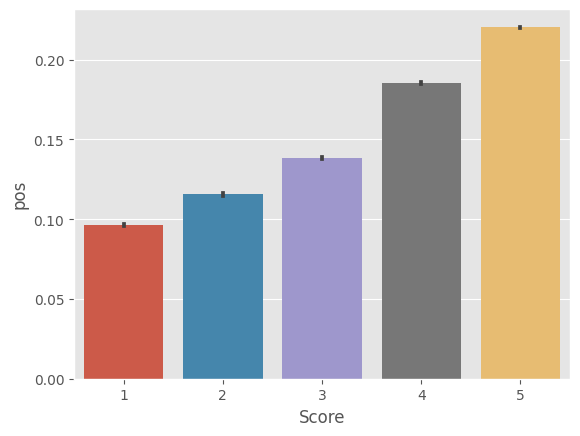

In [20]:
sns.barplot(data = vaders, x = 'Score', y = 'pos')

In [21]:
## Roberta Pretrained Model

In [24]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [25]:
Model = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(Model)
model = AutoModelForSequenceClassification.from_pretrained(Model)

In [27]:
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [30]:
# Run for the Roberta Model 
encoded_text = tokenizer(example, return_tensors= 'pt')
output = model(**encoded_text)

In [31]:
output

SequenceClassifierOutput(loss=None, logits=tensor([[ 3.1436, -0.7107, -2.6559]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [32]:
scores = output[0][0].detach().numpy()

In [33]:
scores

array([ 3.143629  , -0.71066886, -2.6558967 ], dtype=float32)

In [35]:
scores = softmax(scores)

In [36]:
scores

array([0.97635514, 0.02068748, 0.00295737], dtype=float32)

In [37]:
scores_dict  ={
    'roberta-neg' : scores[0],
    'roberta-neu' : scores[1],
    'roberta-pos' : scores[2]
}

In [38]:
scores_dict

{'roberta-neg': 0.97635514,
 'roberta-neu': 0.020687476,
 'roberta-pos': 0.0029573708}

In [54]:
def roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict  ={
    'roberta-neg' : scores[0],
    'roberta-neu' : scores[1],
    'roberta-pos' : scores[2]
    }  
    return scores_dict

In [55]:
example_1 = 'I like you'
roberta(example_1)

{'roberta-neg': 0.00879873,
 'roberta-neu': 0.12146878,
 'roberta-pos': 0.8697325}

In [57]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
            text = row['Text']
            id = row['Id']
            vader_result = sia.polarity_scores(text)
            vader_result_rename = {}
            for key, value in vader_result.items():
                vader_result_rename[f"vader_{key}"] = value
            roberta_result = roberta(text)
            both = {**vader_result_rename, **roberta_result}

            res[id]  = both
  
    except:
            print(f'Broke for id = {id},')

  0%|          | 0/568454 [00:00<?, ?it/s]

Broke for id = 83,
Broke for id = 187,
Broke for id = 529,
Broke for id = 540,
Broke for id = 746,
Broke for id = 863,
Broke for id = 1053,
Broke for id = 1070,
Broke for id = 1156,
Broke for id = 1321,
Broke for id = 1375,
Broke for id = 1498,
Broke for id = 1575,
Broke for id = 1796,
Broke for id = 1826,
Broke for id = 2169,
Broke for id = 2248,
Broke for id = 2476,
Broke for id = 2492,
Broke for id = 2584,
Broke for id = 2610,
Broke for id = 2897,
Broke for id = 2898,
Broke for id = 2902,
Broke for id = 2928,
Broke for id = 2942,
Broke for id = 2944,
Broke for id = 2947,
Broke for id = 2948,
Broke for id = 3022,
Broke for id = 3023,
Broke for id = 3025,
Broke for id = 3306,
Broke for id = 3788,
Broke for id = 3969,
Broke for id = 4107,
Broke for id = 4110,
Broke for id = 4307,
Broke for id = 4316,
Broke for id = 4408,
Broke for id = 4483,
Broke for id = 4512,
Broke for id = 4553,
Broke for id = 4583,
Broke for id = 5040,
Broke for id = 5182,
Broke for id = 5192,
Broke for id = 5365,